## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [76]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

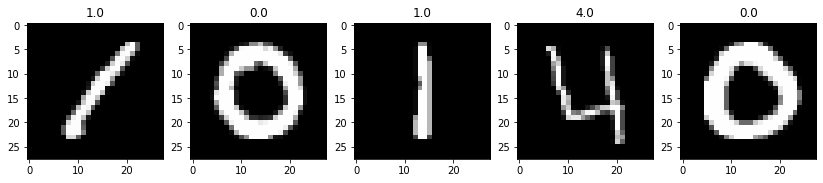

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

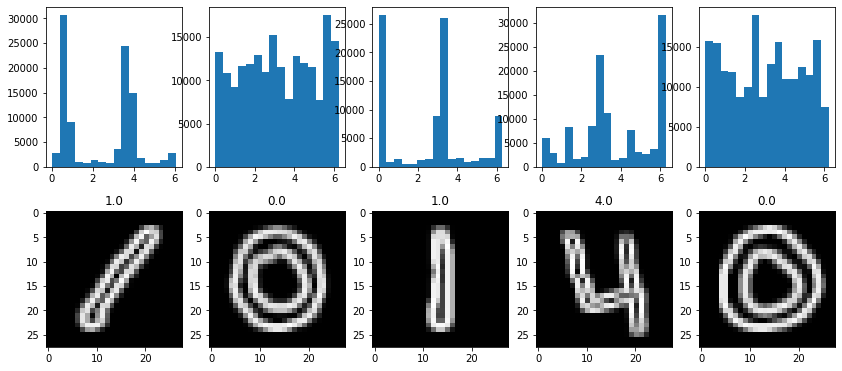

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Используем RandomForestClassifier для классификации

In [59]:
forest = RandomForestClassifier(n_estimators=100, 
                                max_depth=12, 
                                min_samples_leaf=3, 
                                random_state=17).fit(x_train, y_train)

In [60]:
pred_val = forest.predict(x_val)

## Предсказание на тестовой выборке 

In [66]:
pred_test = forest.predict(test_hist)

In [73]:
pred_test = pred_test.astype(int)

## Оцениваем качество решение на валидационной выборке

In [61]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.6309523809523809


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.42      0.35      0.39       816
         1.0       0.98      0.96      0.97       909
         2.0       0.50      0.42      0.46       846
         3.0       0.62      0.69      0.66       937
         4.0       0.70      0.68      0.69       839
         5.0       0.62      0.65      0.63       702
         6.0       0.45      0.44      0.45       785
         7.0       0.86      0.79      0.82       893
         8.0       0.48      0.58      0.53       835
         9.0       0.62      0.69      0.66       838

    accuracy                           0.63      8400
   macro avg       0.63      0.62      0.62      8400
weighted avg       0.63      0.63      0.63      8400



In [63]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[288   5  62  35  43  19 135  13 176  40]
 [  2 870   2   0  21   0   1   7   0   6]
 [ 52   0 358 145   1 104  57  17  95  17]
 [ 20   0  71 648   0  86  10   2  90  10]
 [ 12  13  10   4 570   1  90  30   6 103]
 [  6   0  71 123   1 453   6   5  36   1]
 [121   1  59   9  66   7 346  11  89  76]
 [  6   2  33   7  44  14  25 702   6  54]
 [122   0  35  54  13  38  39   7 487  40]
 [ 51   1  22  14  60   5  52  20  35 578]]


## Визуализируем предсказания

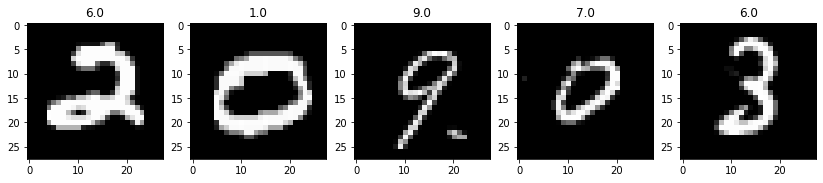

In [64]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_val[i - 1]);

## Готовим файл для отправки

In [74]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [75]:
!head submit.txt

ImageId,Label
1,2
2,5
3,9
4,8
5,8
6,7
7,0
8,3
9,3
